# Benching Gaussian Naive Bayes over Varying Dataset Sizes

author: Nicholas Farn [<a href="sendto:nicholasfarn@gmail.com">nicholasfarn@gmail.com</a>]

This is a simple benchmark comparing the speed of the fit and predict methods of scikit-learn's Gaussian Naive Bayes to the same methods in pomegranate's Naive Bayes.

In [1]:
from sklearn.naive_bayes import GaussianNB
from pomegranate import *
import numpy as np
import time
import seaborn
%pylab inline
seaborn.set_style('whitegrid')

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


First there is our data set that we use to test both scikit-learn and pomegranate. The data set consists of 300,000 5-dimensional normally distributed points. The data has an equal number of samples for all three components. The data is generated by using numpy's randn function, then shuffling the points. The data is also made in a staggered fashion, so that an even number of samples for each component is contained in the first 10, then 30, then 100, etc. samples. The size roughly increases by a factor of 3 each time.

In [2]:
sizes = [ 10, 30, 100, 300, 1000, 3000, 10000, 30000, 100000 ]
d = 5

X = np.concatenate(( np.random.randn(sizes[0], d) + 2,
					 np.random.randn(sizes[0], d) + 3,
					 np.random.randn(sizes[0], d) + 4))

y = np.concatenate(( np.zeros(sizes[0]), np.ones(sizes[0]), np.ones(sizes[0]) + 1))

index = np.arange( 3*sizes[0] )
np.random.shuffle( index )

X = X[index]
y = y[index]

for i in range(1, len(sizes)):
	size = sizes[i] - sizes[i-1]

	temp_X = np.concatenate(( np.random.randn(size, d) + 2,
							  np.random.randn(size, d) + 3,
							  np.random.randn(size, d) + 4))
	temp_y = np.concatenate(( np.zeros(size), np.ones(size), np.ones(size) + 1))
	
	index = np.arange( 3*size )
	np.random.shuffle( index )

	X = np.concatenate( ( X, temp_X[index] ) )
	y = np.concatenate( ( y, temp_y[index] ) )

We now create our scikit-learn and pomegranate gaussian naive bayes instances. Note that the type of distribution must be passed into pomegranate's implementation of naive bayes. This has advantages and disadvantages as any model that can output a probability can be used in pomegranate's implementation of naive bayes.

In [3]:
skl = GaussianNB()
pom = NaiveBayes( MultivariateGaussianDistribution )

We now feed in our data set from before in order to bench the fit and prediction times and relative error of each implementation. We use the staggered feature of our data set in order to easily bench each implementation on data sets of various sizes without having to generate a new one for each size.

In [4]:
skl_predict = list()
skl_fit = list()
skl_error = list()

pom_predict = list()
pom_fit = list()
pom_error = list()

for i in range(len(sizes)):
	size = 3*sizes[i]
    
	# bench fit times
	tic = time.time()
	skl.fit( X[:size], y[:size] )
	skl_fit.append( time.time() - tic )

	tic = time.time()
	pom.fit( X[:size], y[:size] )
	pom_fit.append( time.time() - tic )

	# bench predict times
	tic = time.time()
	skl_predictions = skl.predict( X[:size] )
	skl_predict.append( time.time() - tic )

	tic = time.time()
	pom_predictions = pom.predict( X[:size] )
	pom_predict.append( time.time() - tic )

	# check number wrong
	skl_error.append( float(( y[:size] != skl_predictions ).sum()) / size )
	pom_error.append( float(( y[:size] != pom_predictions ).sum()) / size )

Exception numpy.linalg.linalg.LinAlgError: LinAlgError('Singular matrix',) in 'pomegranate.distributions.MultivariateGaussianDistribution._from_summaries' ignored
Exception numpy.linalg.linalg.LinAlgError: LinAlgError('Singular matrix',) in 'pomegranate.distributions.MultivariateGaussianDistribution._from_summaries' ignored
Exception numpy.linalg.linalg.LinAlgError: LinAlgError('Singular matrix',) in 'pomegranate.distributions.MultivariateGaussianDistribution._from_summaries' ignored


Now we can view our results. Below is a plot of the benched speed for fitting for both scikit-learn and pomegranate over the number of samples per a component. As you can see, pomegranate is slightly faster in fitting than scikit-learn. Note that all of the plots are logarithmic.

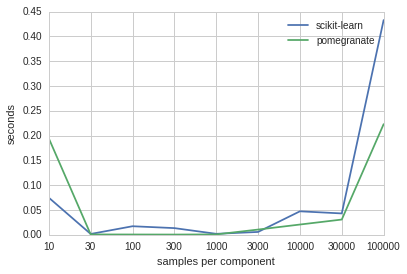

In [5]:
skl_line, = pylab.plot(skl_fit, label='scikit-learn')
pom_line, = pylab.plot(pom_fit, label='pomegranate')
pylab.xticks(range(9), sizes)
pylab.xlabel('samples per component')
pylab.ylabel('seconds')
pylab.legend(handles=[skl_line, pom_line])
pylab.show()

Here is a plot of the benched speed for prediction for both scikit-learn and pomegranate over number of samples per component. Note that while scikit-learn and pomegranate have relatively the same speed for smaller data sizes, pomegranate benchmark speed increases at a faster rate than scikit-learn.

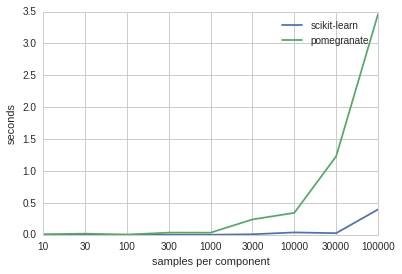

In [6]:
skl_line, = pylab.plot(skl_predict, label='scikit-learn')
pom_line, = pylab.plot(pom_predict, label='pomegranate')
pylab.xticks(range(9), sizes)
pylab.xlabel('samples per component')
pylab.ylabel('seconds')
pylab.legend(handles=[skl_line, pom_line])
pylab.show()

However pomegranate overall generally has less error than scikit-learn though this diminishes for larger data sets. This following plot shows the fraction of wrongly labeled samples out of the total number of samples. We believe this higher error is due to pomegranate training the full covariance matrix while scikit-learn only trains the diagonal. This has advantages and disadvantages as we can see pomegranate's prediction speed is a decent bit higher than scikit learn's for larger data sets.

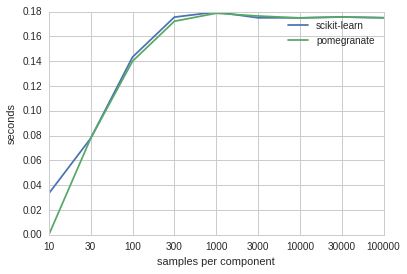

In [7]:
skl_line, = pylab.plot(skl_error, label='scikit-learn')
pom_line, = pylab.plot(pom_error, label='pomegranate')
pylab.xticks(range(9), sizes)
pylab.xlabel('samples per component')
pylab.ylabel('seconds')
pylab.legend(handles=[skl_line, pom_line])
pylab.show()

As one can see, in terms of speed, scikit-learn and pomegranate tend to have similar speeds for smaller data sets, with scikit-learn scaling better with larger sizes. Error is better for pomegranate for smaller data sizes though it peters out as the data set gets larger.

However while scikit-learn's speed tends to be better overall, pomegranate's implementation of naive bayes implements more than just gaussian, bernoulli, and discrete distributions etc. So while pomegranate might lose in terms of speed, one must keep in mind that any model can be used, including a mixture of models assuming similar inputs. For example conditional probability tables, hidden markov models, uniform distributions with normal and exponential, etc.